<a href="https://colab.research.google.com/github/19marquee/rabbit-challenge/blob/main/deep-learning/day1section5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# レポート 深層学習day1/Section5:誤差逆伝搬法

## 100文字以内の要点のまとめ

- 勾配の計算方法として、数値微分があるが、計算量が膨大で計算機への負荷が大きい。
- 誤差逆伝搬法：算出した誤差を出力層側から順に微分し、前の層へと伝搬していく手法。微分を逆算することで、不要な再帰的計算を避けて微分を行うことができる。（チェインルール）

##実装演習結果

#### 準備

#### Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

#### minst

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.31
                : 10. 正答率(テスト) = 0.2479
Generation: 20. 正答率(トレーニング) = 0.18
                : 20. 正答率(テスト) = 0.1318
Generation: 30. 正答率(トレーニング) = 0.17
                : 30. 正答率(テスト) = 0.2394
Generation: 40. 正答率(トレーニング) = 0.5
                : 40. 正答率(テスト) = 0.5352
Generation: 50. 正答率(トレーニング) = 0.74
                : 50. 正答率(テスト) = 0.5883
Generation: 60. 正答率(トレーニング) = 0.63
                : 60. 正答率(テスト) = 0.5232
Generation: 70. 正答率(トレーニング) = 0.59
                : 70. 正答率(テスト) = 0.6023
Generation: 80. 正答率(トレーニング) = 0.68
                : 80. 正答率(テスト) = 0.6987
Generation: 90. 正答率(トレーニング) = 0.79
                : 90. 正答率(テスト) = 0.6556
Generation: 100. 正答率(トレーニング) = 0.74
                : 100. 正答率(テスト) = 0.7341
Generation: 110. 正答率(トレーニング) = 0.74
                : 110. 正答率(テスト) = 0.7222
Generation: 120. 正答率(トレーニング) = 0.74
                : 120. 正答率(テスト) = 0.7556
Generation: 130. 正答率(トレーニング) = 0.77
                : 130. 正答率(テスト) = 0.7875
Generati

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31572 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text

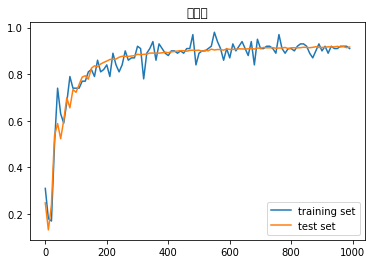

In [3]:
import numpy as np
from data.mnist import load_mnist
import pickle
from common import functions
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01 # 変更してみよう
#入力層サイズ
input_layer_size = 784 # 変更してみよう
#中間層サイズ
hidden_layer_size = 40 # 変更してみよう
#出力層サイズ
output_layer_size = 10 # 変更してみよう
# 繰り返し数
iters_num = 1000 # 変更してみよう
# ミニバッチサイズ
batch_size = 100 # 変更してみよ
# 学習率
learning_rate = 0.1 # 変更してみよう
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 
    network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_size)
    network['W2'] = wieght_init * np.random.randn(hidden_layer_size, output_layer_size)
    # 試してみよう_Xavierの初期値
    # network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size)
    # network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size)
    # 試してみよう Heの初期値
    # network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size) * np.sqrt(2)
    # network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)

    network['b1'] = np.zeros(hidden_layer_size)
    network['b2'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2 = network['W1'], network['W2']
    b1, b2  = network['b1'], network['b2']
        
    u1 =  np.dot(x, W1) + b1
    z1 = functions.relu(u1)
    u2 =  np.dot(z1, W2) + b2
    y = functions.softmax(u2)
 
    return z1, y

# 誤差逆伝播
def backward(x, d, z1, y):
    grad = {}
    
    W1, W2 = network['W1'], network['W2']
    b1, b2 = network['b1'], network['b2']    
    # 出力層でのデルタ
    delta2 = functions.d_softmax_with_loss(d, y)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()


accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'b1', 'b2'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("正答率")
# グラフの表示
plt.show()

MNISTデータの誤差逆伝搬法を用いた学習とその結果を確認。約200epochで精度が90%を超える。

##確認テスト

・誤差逆伝播法では不要な再帰的処理を避ける事が出来る。既に行った計算結果を保持しているソースコードを抽出せよ。

解答  

```
# 出力層でのデルタ
delta2 = functions.d_mean_squared_error(d, y)
```



・以下2つの数式に該当するソースコードを探せ  
⑴  
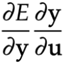

⑵  
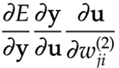

解答  

⑴

```
delta1 = np.dot(delta2, W2.T) * functions.d_sigmoid(z1)
```
⑵

```
grad['W1'] = np.dot(x.T, delta1)
```


※⑴⑵ともに、誤差逆伝搬の関数から抜粋
```
# 誤差逆伝播
def backward(x, d, z1, y):
    # print("\n##### 誤差逆伝播開始 #####")    

    grad = {}
    
    W1, W2 = network['W1'], network['W2']
    b1, b2 = network['b1'], network['b2']

    # 出力層でのデルタ
    delta2 = functions.d_mean_squared_error(d, y)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 中間層でのデルタ  
    #delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)

    ## 試してみよう
    delta1 = np.dot(delta2, W2.T) * functions.d_sigmoid(z1)

    delta1 = delta1[np.newaxis, :]
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    x = x[np.newaxis, :]
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)
    
    # print_vec("偏微分_重み1", grad["W1"])
    # print_vec("偏微分_重み2", grad["W2"])
    # print_vec("偏微分_バイアス1", grad["b1"])
    # print_vec("偏微分_バイアス2", grad["b2"])

    return grad
```


